 **This is example demonstrates the time-series forecasting using methods of Moving Average (MA), Linear Regression (LR), Deep Neural Network (DNN) and Long Short-Term Memory (LSTM). Time-series data are generated with seasonality, trend and noise.**

**The notebook was created by Randa Natras, contact: randa.natras@hotmail.com**

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

First we will set up the time series data with seasonality, trend and a little noise.

In [2]:
#The general functions for generating time-series data are taken
#from the course: "Sequences, Time Series and Prediction" offered via Coursera, 
#and adapted for the example in this notebook.

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.6,
                    np.cos(season_time * 3 * np.pi),
                    1 / np.exp(2 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

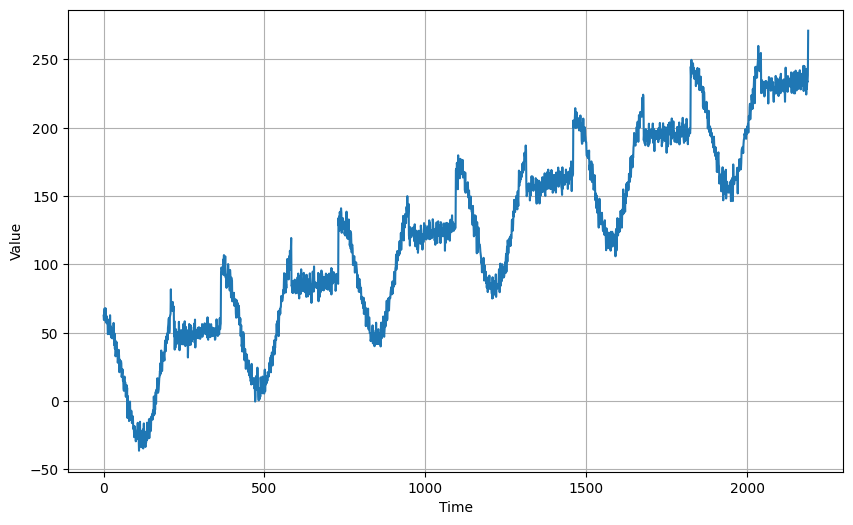

In [3]:
time = np.arange(6 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 50
slope = 0.1
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now that we have the time series, we can split it into training and validation data and start forecasting.

In [7]:
split_time = 1500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

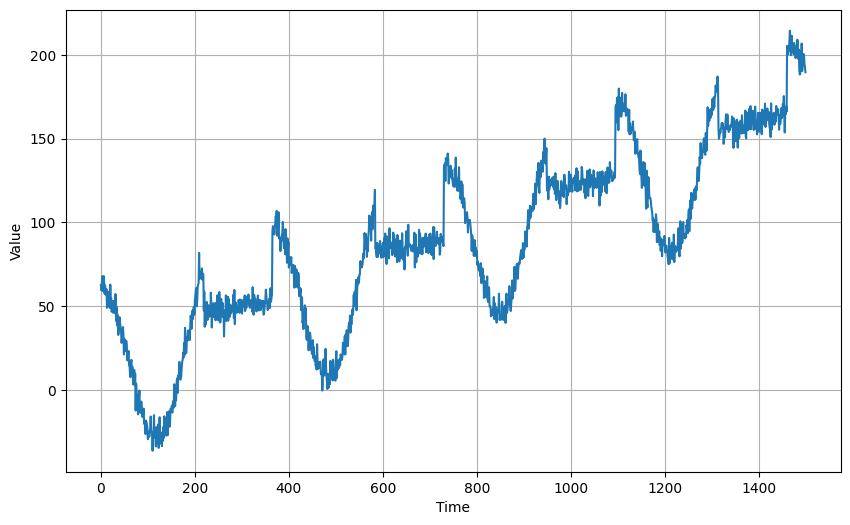

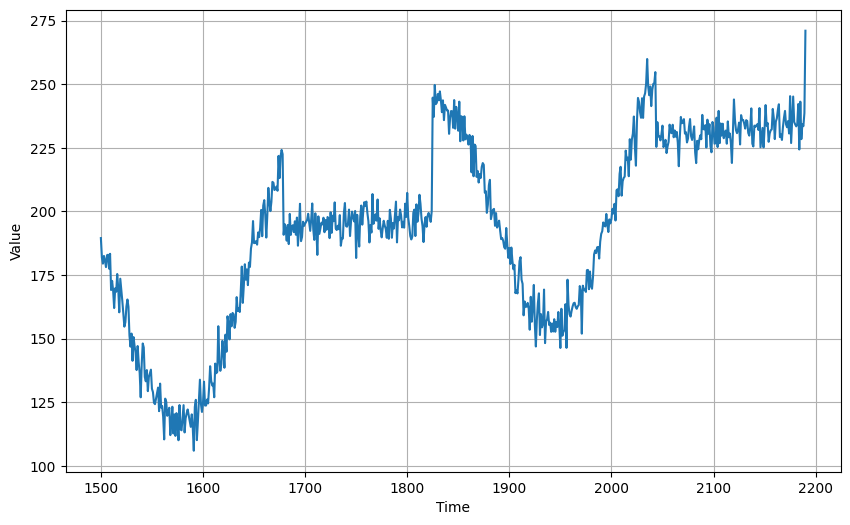

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

## Naive Forecast

In naive forecasting, the actual observed value of the last period is used as the forecast for the next period.

In [ ]:
naive_forecast = series[split_time - 1:-1]

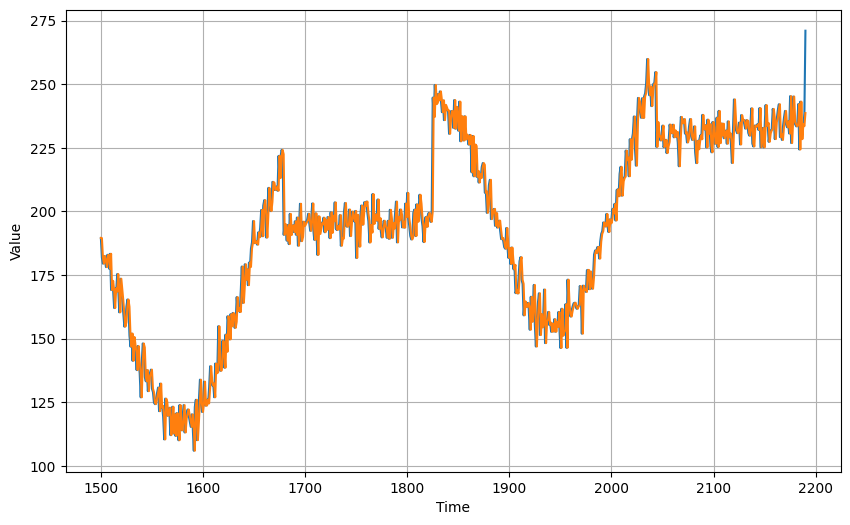

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Let's zoom in to the beginning of the validation period:

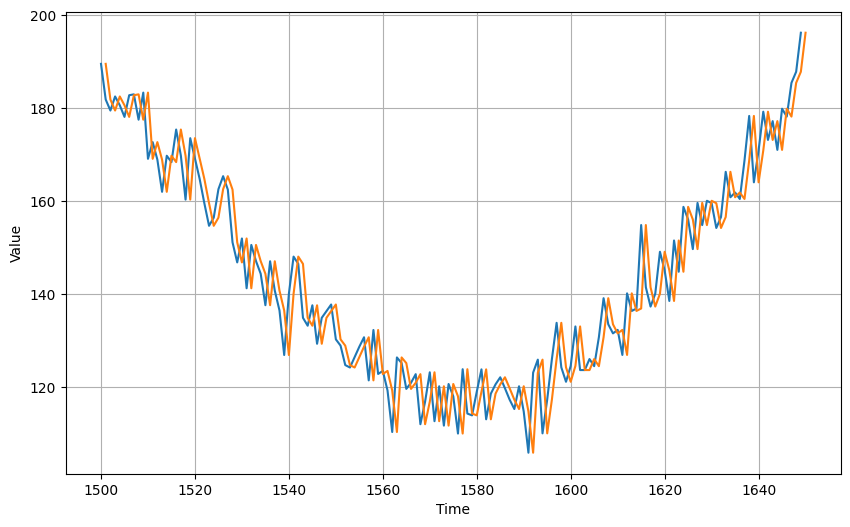

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

The naive forecast lags by 1 step behind the time series.

Let us now calculate the mean square error (mse) and the mean absolute error (mae) between the forecasts and the observed time series data in the validation period:

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

55.495823
5.701095


That's our baseline, now let's try a moving average.

## Moving Average (MA) Forecast

In [4]:
#Forecasts the mean of the last few values defined with window_size.
# If window_size=1, then this will be equivalent to naive forecast

def moving_average_forecast(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

Moving average of the last 30 values.

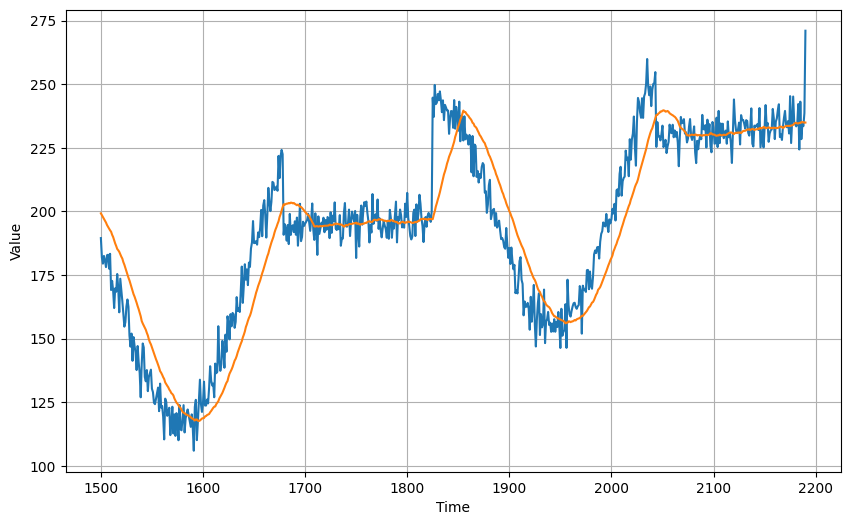

In [8]:
moving_avg = moving_average_forecast(series,30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

The forecast results are clearly shifted.

In [9]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

188.37483
10.790653


Let's try moving average of the last 10 values.

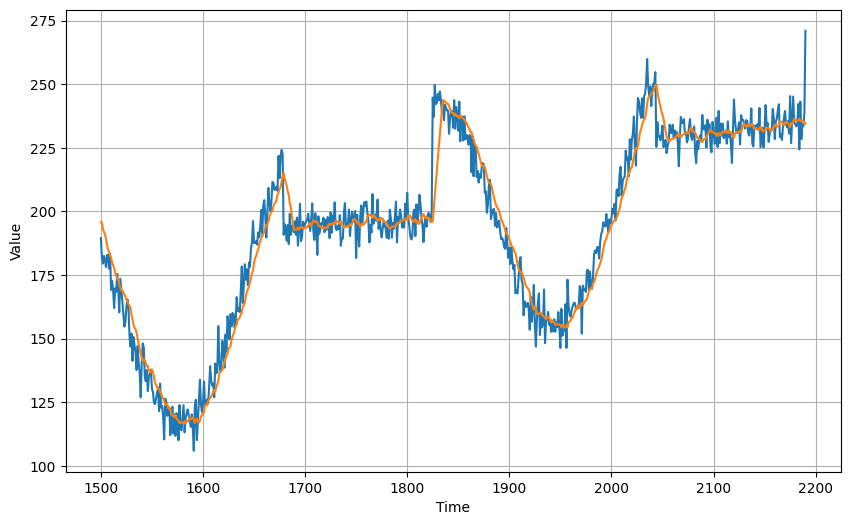

In [10]:
moving_avg = moving_average_forecast(series, 10)[split_time - 10:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [11]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

63.6724
5.897482


Forecasting based on the moving average lead to worse results than naïve forecasts! The moving average anticipates neither trend nor seasonality. Let's try to remove them with the method of differencing. The period of seasonality is 365 days, so we can subtract the value at time *t* - 365 from the value at time *t*.

In [5]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

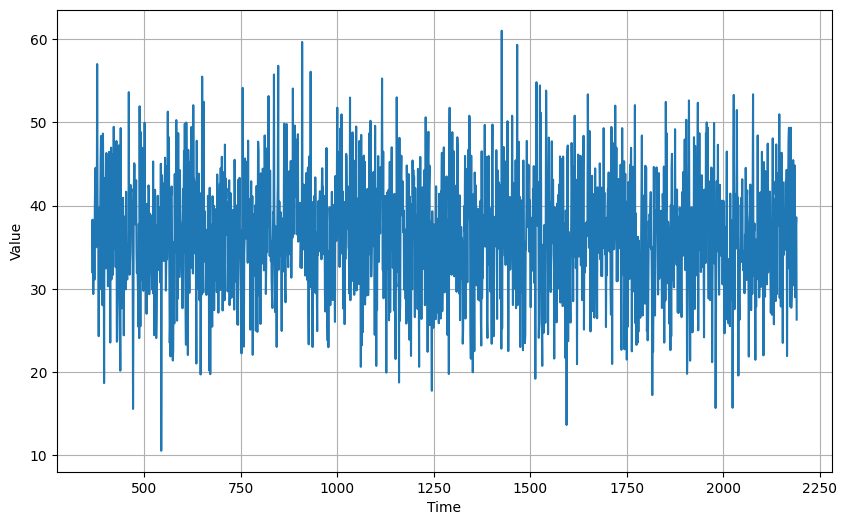

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Differencing based on seasonality helped to stabilise the mean of a time series, and eliminated seasonailty and reduced trend.
Now the moving average can be applied to differenced time series.



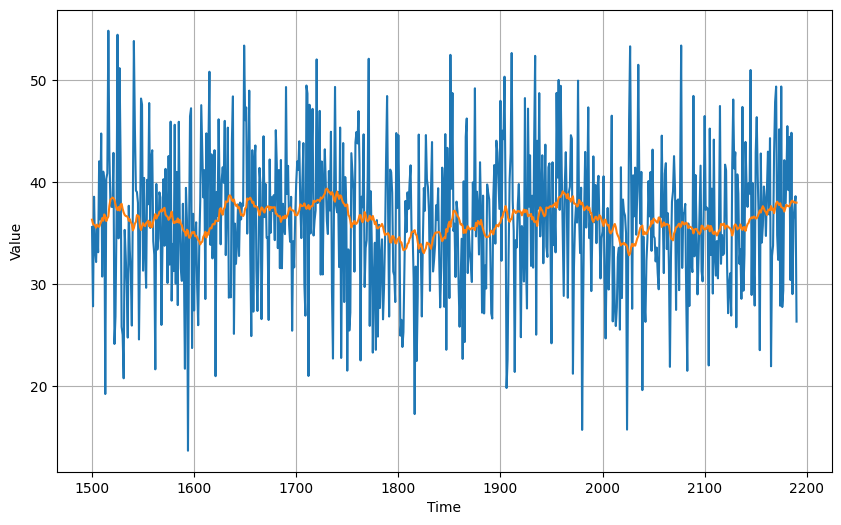

In [21]:
diff_moving_avg = moving_average_forecast(diff_series, 30)[split_time - 365 - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

To transform differenced data into original dataset, the trend and seasonality needs to be returned by adding the past values from t – 365:

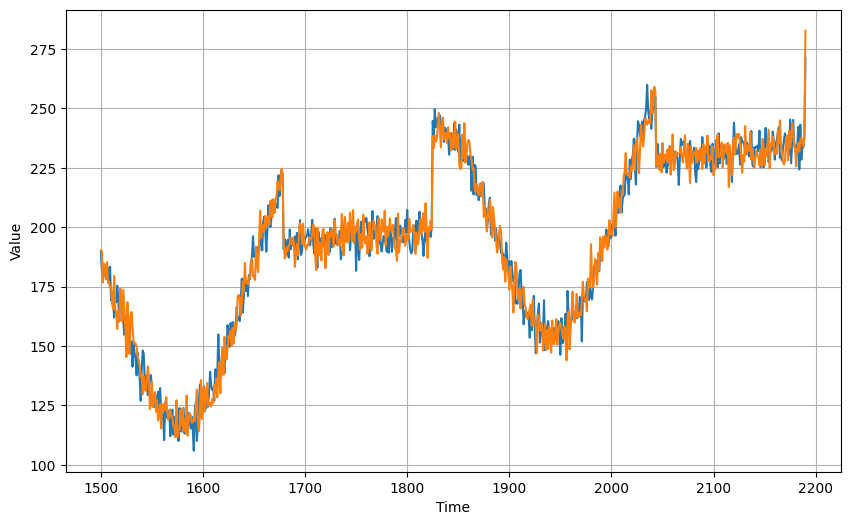

In [22]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [23]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

50.824734
5.656467


The results are now better than with the naive forecast. However the forecasts look a bit too noisy, because past values were added, which were noisy too. Let's use a moving averaging over the last 10 values to remove some of the noise and get smoother seasonal and trend signal, which will be added to the forecasted differenced time series.

In [119]:
moving_ave_10 = moving_average_forecast(series[split_time - 370:-360], 10)

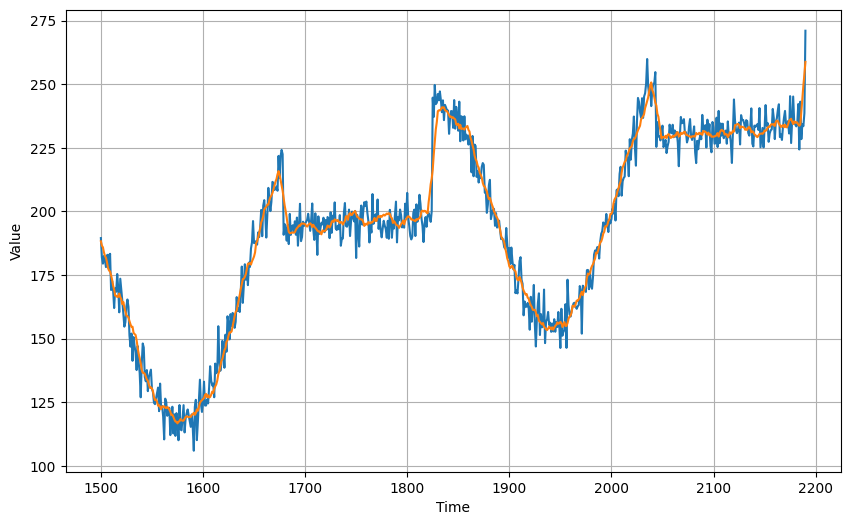

In [25]:
diff_moving_avg_plus_smooth_past = moving_ave_10 + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [26]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.290916
4.4707994


The results are much better now than before.

## **Linear Regression (LR)**

Firstly, dataset will be partitioned into subsections or windows (which increases the dimension shape of the dataset).

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [15]:
window_size = 30
batch_size = 50
shuffle_buffer_size = 1000

In [16]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [17]:
dataset_valid = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(dataset_valid)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [18]:
x_train_diff = diff_series[: split_time - 365]
x_valid_diff = diff_series[split_time - 365:]

In [19]:
dataset_train_diff = windowed_dataset(x_train_diff, window_size, batch_size, shuffle_buffer_size)
dataset_valid_diff = windowed_dataset(x_valid_diff, window_size, batch_size, shuffle_buffer_size)

In [ ]:
#Linear regression compiling and fitting
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])  #linear regression
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)) #stochastic gradient descent
model.fit(dataset,epochs=100,verbose=0) #run for 100 epochs (iterations), ignoring epoch by epoch output by setting verbose=0

print("Layer weights {}".format(l0.get_weights())) #inspect weights

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Layer weights [array([[-0.02630849],
       [ 0.00522296],
       [ 0.02560232],
       [-0.02889662],
       [ 0.04005104],
       [-0.04189156],
       [-0.05439657],
       [ 0.0125979 ],
       [ 0.03816177],
       [-0.00135146],
       [-0.00148386],
       [-0.04957929],
       [ 0.01547707],
       [-0.01585282],
       [ 0.05688785],
       [-0.03892794],
       [ 0.05959651],
       [-0.01645643],
       [-0.01206995],
       [-0.02712433],
       [-0.0216208 ],
       [ 0.02818176],
       [ 0.01183958],
       [-0.02188675],
       [ 0.04978246],
       [ 0.00892538],
       [ 0.09625494],
       [ 0.20512144],
       [ 0.32575533],
       [ 0.3732551 ]], dtype=float32), array([0.01528658], dtype=float32)]


In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

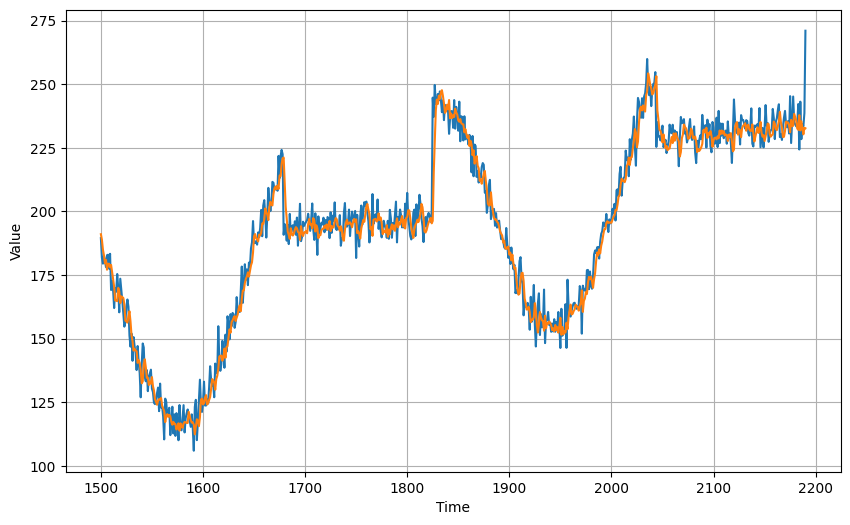

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

44.56772
4.988932


Training with differenced data (removed seasonality and reduced trend).

In [ ]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])  #linear regression
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)) #stochastic gradient descent
model.fit(dataset_train_diff,epochs=100,verbose=0)

In [ ]:
forecast = []
for time in range(len(diff_series) - window_size):
  forecast.append(model.predict(diff_series[time:time + window_size][np.newaxis]))

Transforming the differenced data into the original dataset by adding the past values from t–365:

In [ ]:
forecast_fin = forecast[split_time-window_size-365:]
results = np.array(forecast_fin)[:, 0, 0]
results_diff = results + series[split_time-365: -365]

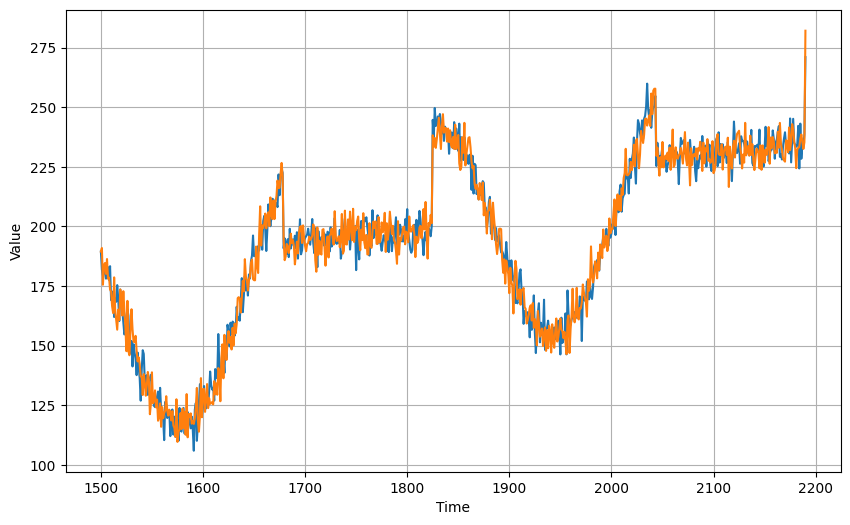

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results_diff)

Transforming the differenced data into the original data set by adding the smoothed historical values of t–365 by moving averaging:

In [ ]:
forecast_fin = forecast[split_time-window_size-365:]
results = np.array(forecast_fin)[:, 0, 0]
results_diff_smooth = results + moving_ave_10

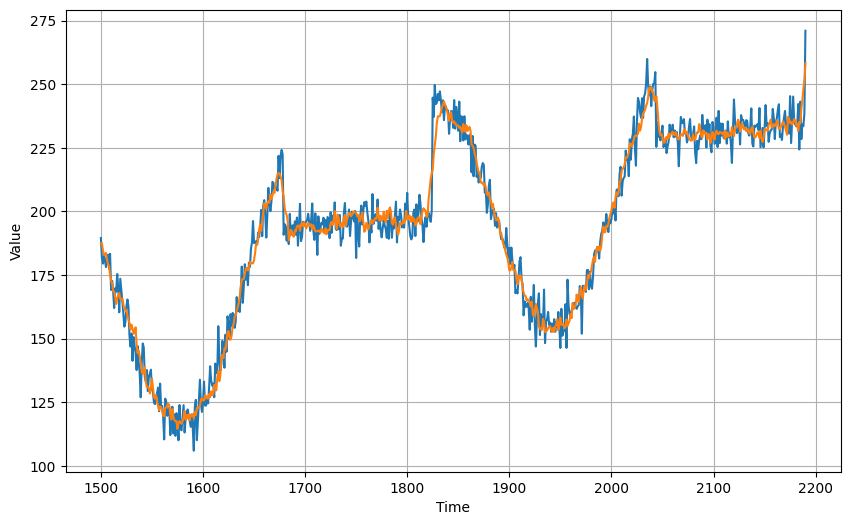

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results_diff_smooth)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, results_diff).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results_diff).numpy())

51.109646
5.653167


In [ ]:
print(keras.metrics.mean_squared_error(x_valid, results_diff_smooth).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results_diff_smooth).numpy())

34.95089
4.555035


## **Deep Neural Network (DNN)**

In [ ]:
#Deep Neural Network (DNN) with two hidden layers
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset, validation_data=dataset_valid, epochs=100,verbose=0)

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 20)                620       
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

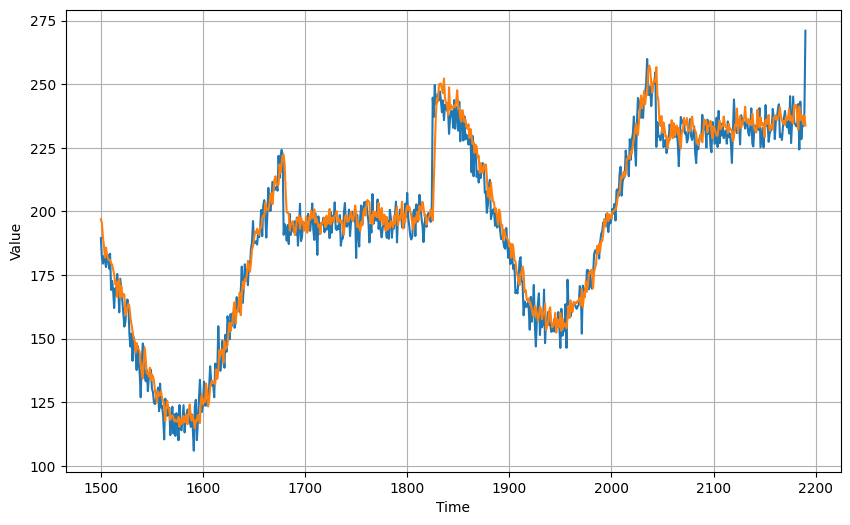

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

51.196487
5.3685284


In [ ]:
# Search for an optimal learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

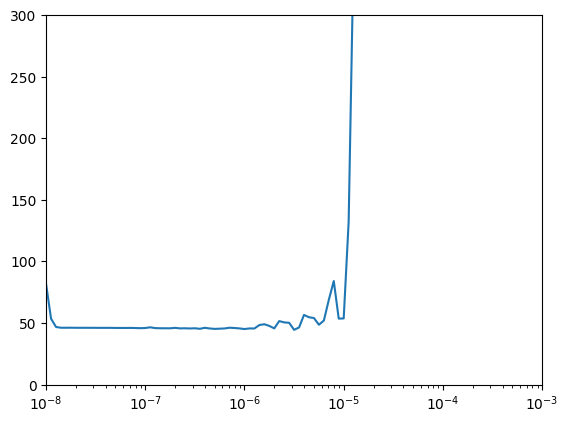

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

The optimal learning rage is 10-6, which was already used in the first run of the model.

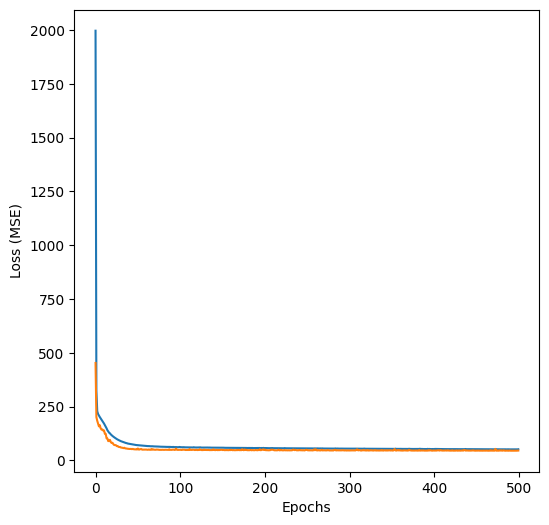

In [ ]:
# summarize history for loss
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
epochs = range(len(train_loss))
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()

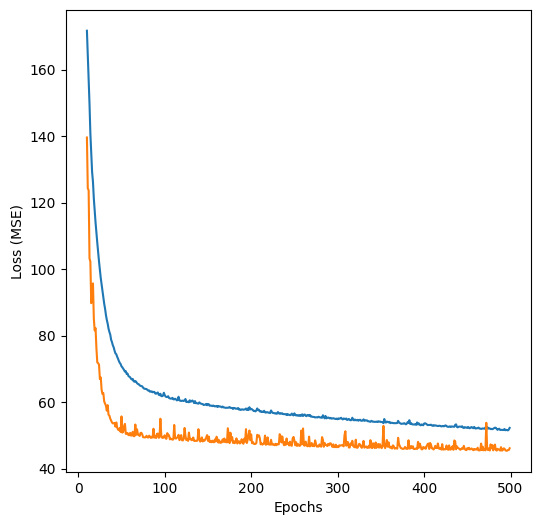

In [ ]:
# Plot all except the first 10
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
epochs = range(10, len(train_loss))
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_loss[10:], label='Training Loss')
plt.plot(epochs, valid_loss[10:], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()

Let's try with differenced data.

In [116]:
#Deep Neural Network (DNN) with two hidden layers
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset_train_diff, validation_data=dataset_valid_diff, epochs=100,verbose=0)

In [ ]:
forecast = []
for time in range(len(diff_series) - window_size):
  forecast.append(model.predict(diff_series[time:time + window_size][np.newaxis]))

Transforming the differenced data into the original data set by adding the smoothed historical values of t–365 by moving averaging:

In [120]:
forecast_fin = forecast[split_time-window_size-365:]
results = np.array(forecast_fin)[:, 0, 0]
results_diff_smooth = results + moving_ave_10

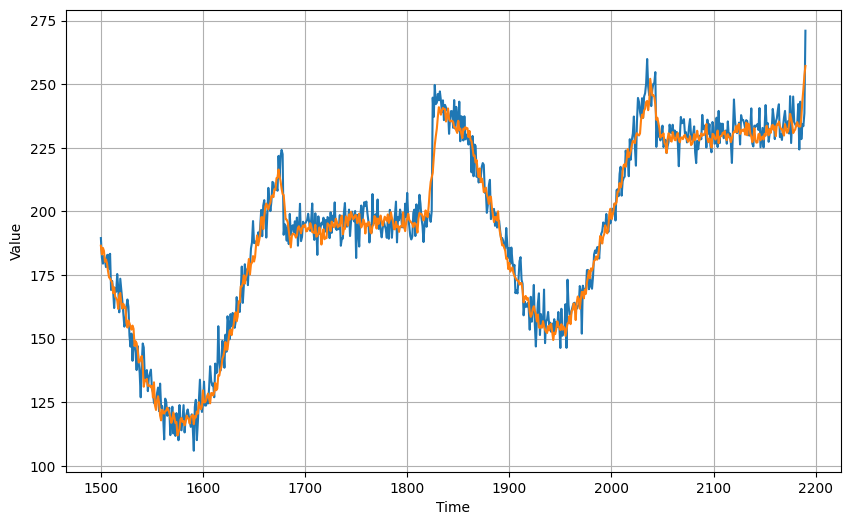

In [121]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results_diff_smooth)

In [122]:
print(keras.metrics.mean_squared_error(x_valid, results_diff_smooth).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results_diff_smooth).numpy())

36.258045
4.705313


Here, too, training with differentiated data and subsequent smoothing leads to better results.

## **Long Short-Term Memory (LSTM)**

Let's try a fully connected bidirectional LSTM, where the output of the previous timestep is fed into the next timestep and the input flows in both directions. Thus, is able to use information from both sides so that the output layer can receive information from past and future states simultaneously.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
  tf.keras.layers.Dense(1, activation='relu'),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mae"])
    
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
30/30 [==============================] - 7s 12ms/step - loss: 3467.8989 - mae: 45.9943 - lr: 1.0000e-08
Epoch 2/100
30/30 [==============================] - 0s 12ms/step - loss: 1758.0542 - mae: 33.4580 - lr: 1.1220e-08
Epoch 3/100
30/30 [==============================] - 0s 12ms/step - loss: 1525.2538 - mae: 32.4662 - lr: 1.2589e-08
Epoch 4/100
30/30 [==============================] - 0s 12ms/step - loss: 1373.8202 - mae: 30.7585 - lr: 1.4125e-08
Epoch 5/100
30/30 [==============================] - 0s 11ms/step - loss: 1215.7565 - mae: 28.5623 - lr: 1.5849e-08
Epoch 6/100
30/30 [==============================] - 0s 12ms/step - loss: 1101.7820 - mae: 27.0361 - lr: 1.7783e-08
Epoch 7/100
30/30 [==============================] - 0s 11ms/step - loss: 1001.2743 - mae: 25.8110 - lr: 1.9953e-08
Epoch 8/100
30/30 [==============================] - 0s 12ms/step - loss: 899.3909 - mae: 24.3865 - lr: 2.2387e-08
Epoch 9/100
30/30 [==============================] - 0s 12ms/step - loss:

(1e-09, 0.001, 0.0, 3000.0)

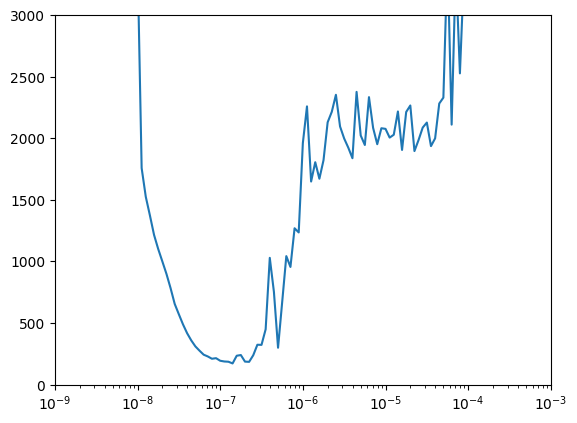

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-9, 1e-3, 0, 3000])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
  tf.keras.layers.Dense(1, activation='relu'),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), 
              metrics=["mae"])
history = model.fit(dataset, epochs=500)

Epoch 1/500
30/30 [==============================] - 7s 12ms/step - loss: 1665.6305 - mae: 33.7705
Epoch 2/500
30/30 [==============================] - 0s 12ms/step - loss: 1124.7238 - mae: 27.9361
Epoch 3/500
30/30 [==============================] - 0s 12ms/step - loss: 707.9925 - mae: 21.8033
Epoch 4/500
30/30 [==============================] - 1s 17ms/step - loss: 485.6648 - mae: 17.7315
Epoch 5/500
30/30 [==============================] - 1s 20ms/step - loss: 324.4890 - mae: 14.2107
Epoch 6/500
30/30 [==============================] - 1s 19ms/step - loss: 253.4092 - mae: 12.4909
Epoch 7/500
30/30 [==============================] - 0s 12ms/step - loss: 235.7845 - mae: 12.0301
Epoch 8/500
30/30 [==============================] - 0s 12ms/step - loss: 213.6052 - mae: 11.3755
Epoch 9/500
30/30 [==============================] - 0s 11ms/step - loss: 222.5985 - mae: 11.6623
Epoch 10/500
30/30 [==============================] - 0s 12ms/step - loss: 212.9957 - mae: 11.4775
Epoch 11/500
30/3

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

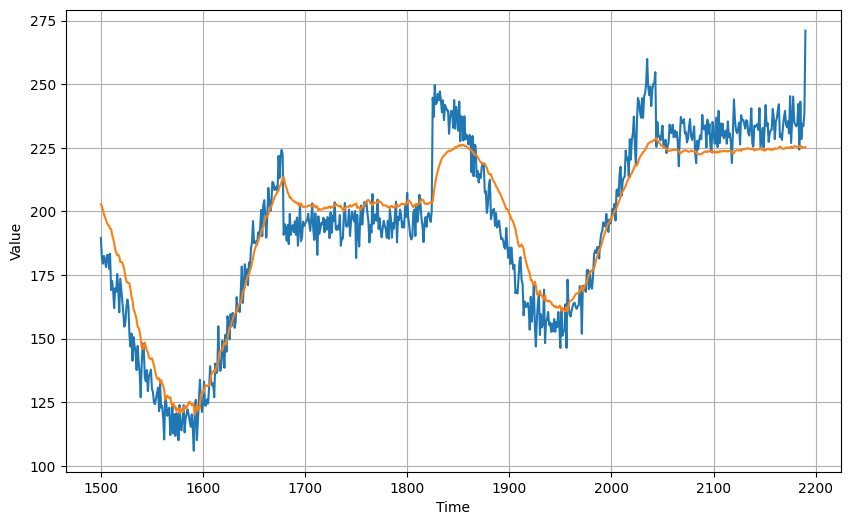

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

124.64827
8.971767


Let's try to incerase number of neurons to 200 in each LSTM layer.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)),
  tf.keras.layers.Dense(1, activation='relu'),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), 
              metrics=["mae"])
history = model.fit(dataset, validation_data=dataset_valid, epochs=500)

Epoch 1/500
30/30 [==============================] - 10s 69ms/step - loss: 908.6064 - mae: 23.1055 - val_loss: 1798.6257 - val_mae: 35.9752
Epoch 2/500
30/30 [==============================] - 1s 23ms/step - loss: 202.8320 - mae: 11.2058 - val_loss: 811.1267 - val_mae: 23.3661
Epoch 3/500
30/30 [==============================] - 1s 18ms/step - loss: 149.1160 - mae: 9.3290 - val_loss: 826.5875 - val_mae: 23.5902
Epoch 4/500
30/30 [==============================] - 1s 24ms/step - loss: 134.7306 - mae: 8.8797 - val_loss: 546.3930 - val_mae: 18.6599
Epoch 5/500
30/30 [==============================] - 1s 24ms/step - loss: 120.3070 - mae: 8.1784 - val_loss: 593.9888 - val_mae: 19.6220
Epoch 6/500
30/30 [==============================] - 1s 30ms/step - loss: 108.7217 - mae: 7.6342 - val_loss: 490.3444 - val_mae: 17.6093
Epoch 7/500
30/30 [==============================] - 1s 19ms/step - loss: 101.7912 - mae: 7.3685 - val_loss: 452.3814 - val_mae: 16.8730
Epoch 8/500
30/30 [==================

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

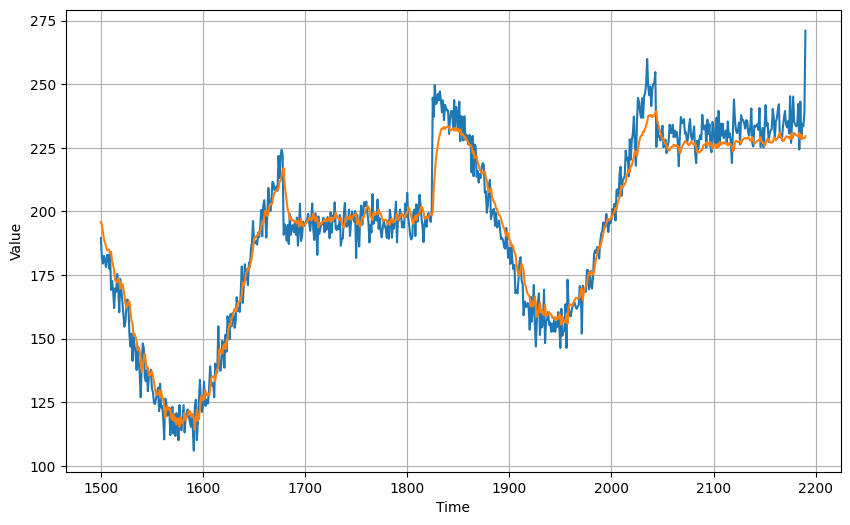

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

58.482296
5.827294


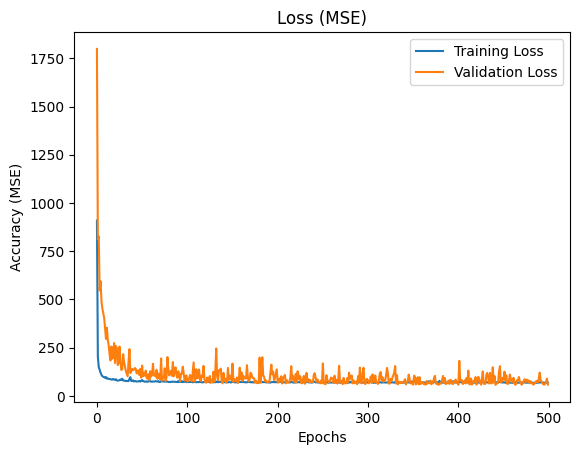

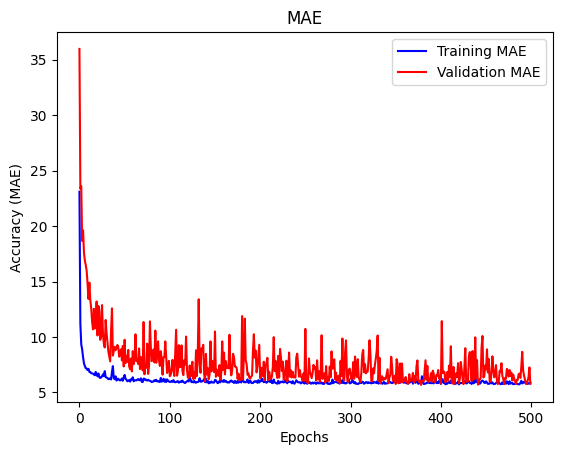

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and validation data sets for each training epoch
#-----------------------------------------------------------
train_mae=history.history['mae']
valid_mae=history.history['val_mae']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

epochs=range(len(train_loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, train_loss)
plt.plot(epochs, valid_loss)
plt.title('Loss (MSE)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (MSE)")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

plt.figure()
plt.plot(epochs, train_mae, 'b')
plt.plot(epochs, valid_mae, 'r')
plt.title('MAE')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (MAE)")
plt.legend(["Training MAE", "Validation MAE"])

Let's try with differenced data.

In [56]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)),
  tf.keras.layers.Dense(1, activation='relu'),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), 
              metrics=["mae"])
history = model.fit(dataset_train_diff, validation_data=dataset_valid_diff, epochs=500)


Epoch 1/500
23/23 [==============================] - 10s 136ms/step - loss: 100.8615 - mae: 8.1590 - val_loss: 71.6813 - val_mae: 6.7262
Epoch 2/500
23/23 [==============================] - 1s 42ms/step - loss: 60.0009 - mae: 6.1460 - val_loss: 54.1924 - val_mae: 5.8826
Epoch 3/500
23/23 [==============================] - 1s 23ms/step - loss: 52.7786 - mae: 5.7536 - val_loss: 50.9374 - val_mae: 5.6403
Epoch 4/500
23/23 [==============================] - 1s 23ms/step - loss: 53.7035 - mae: 5.7790 - val_loss: 50.8376 - val_mae: 5.6600
Epoch 5/500
23/23 [==============================] - 1s 52ms/step - loss: 52.0743 - mae: 5.7427 - val_loss: 50.4450 - val_mae: 5.6374
Epoch 6/500
23/23 [==============================] - 1s 41ms/step - loss: 51.8992 - mae: 5.6947 - val_loss: 59.0503 - val_mae: 6.1825
Epoch 7/500
23/23 [==============================] - 1s 21ms/step - loss: 53.0654 - mae: 5.7995 - val_loss: 50.0364 - val_mae: 5.6092
Epoch 8/500
23/23 [==============================] - 1s 22m

In [ ]:
forecast = []
for time in range(len(diff_series) - window_size):
  forecast.append(model.predict(diff_series[time:time + window_size][np.newaxis]))

Transforming the differenced data into the original data set by adding the smoothed historical values of t–365 by moving averaging:

In [40]:
forecast_fin = forecast[split_time-window_size-365:]
results = np.array(forecast_fin)[:, 0, 0]
results_diff_smooth = results + moving_ave_10

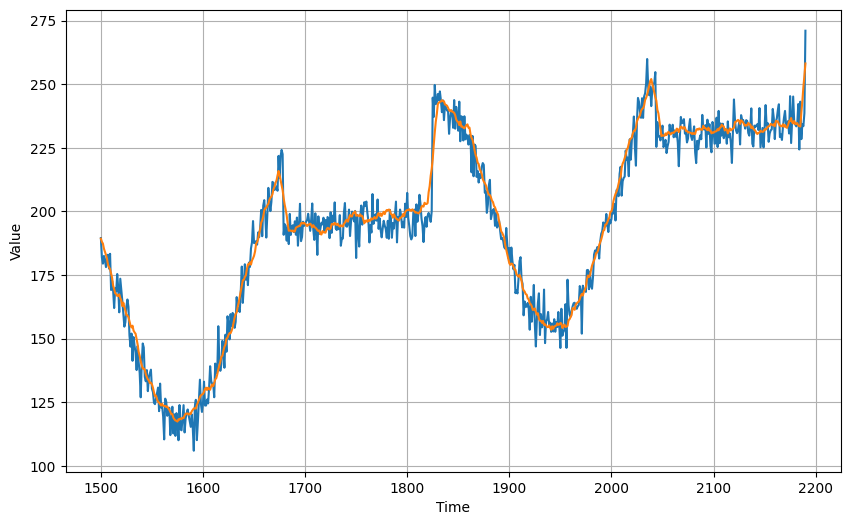

In [41]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results_diff_smooth)

In [42]:
print(keras.metrics.mean_squared_error(x_valid, results_diff_smooth).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results_diff_smooth).numpy())

33.53172
4.489016


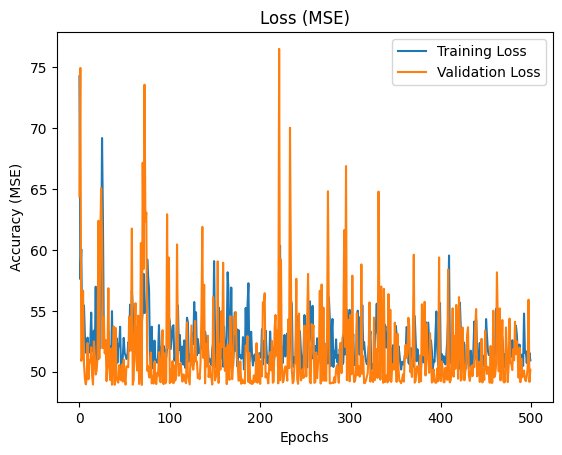

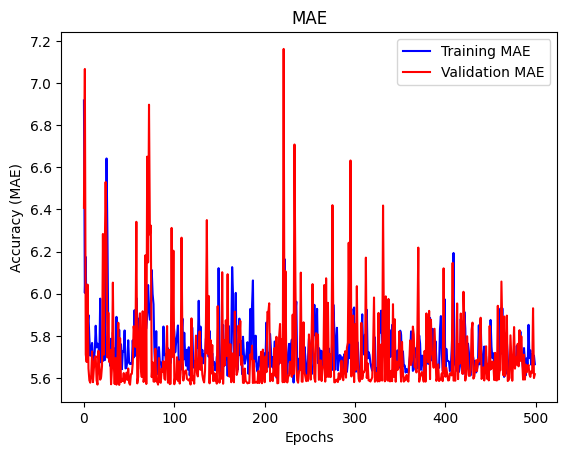

In [55]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and validation data sets for each training epoch
#-----------------------------------------------------------
train_mae=history.history['mae']
valid_mae=history.history['val_mae']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

epochs=range(len(train_loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, train_loss)
plt.plot(epochs, valid_loss)
plt.title('Loss (MSE)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (MSE)")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

plt.figure()
plt.plot(epochs, train_mae, 'b')
plt.plot(epochs, valid_mae, 'r')
plt.title('MAE')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (MAE)")
plt.legend(["Training MAE", "Validation MAE"])

# **Statistics on the final models**

In [123]:
# [MSE, MAE]
naive = [55.4959, 5.7011]

#Moving average over previous 30 values MA_30
MA_30 = [188.3748, 10.7907]

#Moving average over previous 10 values MA_10
MA_10 = [63.6724, 5.8975]

#Moving average with differenced data
MA_30_diff = [50.8247, 5.6565]
MA_30_diff_smooth = [33.2909, 4.4708]

LR = [44.5677, 4.9889]
LR_diff = [51.1096, 5.6532]
LR_diff_smooth = [34.9509, 4.5550]

DNN = [51.1965, 5.3685]
DNN_diff_smooth = [36.2580, 4.7053]

LSTM = [58.4823, 5.8273]
LSTM_diff_smooth = [33.5317, 4.4890]

In [124]:
x = ['Naive', 'MA_30', 'MA_10', 'MA_30_diff', 'MA_30_diff_smooth', 
     'LR', 'LR_diff', 'LR_diff_smooth',
     'DNN', 'DNN _diff_smooth', 'LSTM', 'LSTM_diff_smooth']

y_mse = [naive[0], MA_30[0], MA_10[0], MA_30_diff[0], MA_30_diff_smooth[0],
     LR[0], LR_diff[0], LR_diff_smooth[0],
     DNN[0], DNN_diff_smooth[0], LSTM[0], LSTM_diff_smooth[0]]

y_mae = [naive[1], MA_30[1], MA_10[1], MA_30_diff[1], MA_30_diff_smooth[1],
     LR[1], LR_diff[1], LR_diff_smooth[1],
     DNN[1], LSTM_diff_smooth[1], LSTM[1], LSTM_diff_smooth[1]]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Naive'),
  Text(1, 0, 'MA_30'),
  Text(2, 0, 'MA_10'),
  Text(3, 0, 'MA_30_diff'),
  Text(4, 0, 'MA_30_diff_smooth'),
  Text(5, 0, 'LR'),
  Text(6, 0, 'LR_diff'),
  Text(7, 0, 'LR_diff_smooth'),
  Text(8, 0, 'DNN'),
  Text(9, 0, 'DNN _diff_smooth'),
  Text(10, 0, 'LSTM'),
  Text(11, 0, 'LSTM_diff_smooth')])

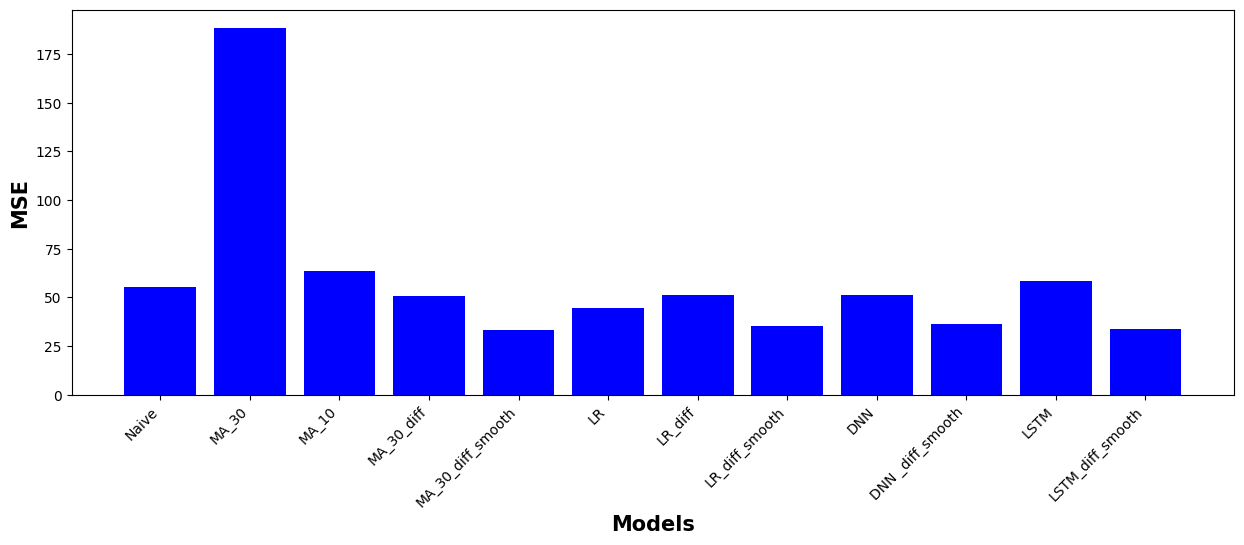

In [125]:
fig = plt.figure(figsize = (15, 5))
plt.bar(x, y_mse, color ='blue')
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE', fontweight ='bold', fontsize = 15)
plt.xticks(rotation=45, ha='right')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Naive'),
  Text(1, 0, 'MA_30'),
  Text(2, 0, 'MA_10'),
  Text(3, 0, 'MA_30_diff'),
  Text(4, 0, 'MA_30_diff_smooth'),
  Text(5, 0, 'LR'),
  Text(6, 0, 'LR_diff'),
  Text(7, 0, 'LR_diff_smooth'),
  Text(8, 0, 'DNN'),
  Text(9, 0, 'DNN _diff_smooth'),
  Text(10, 0, 'LSTM'),
  Text(11, 0, 'LSTM_diff_smooth')])

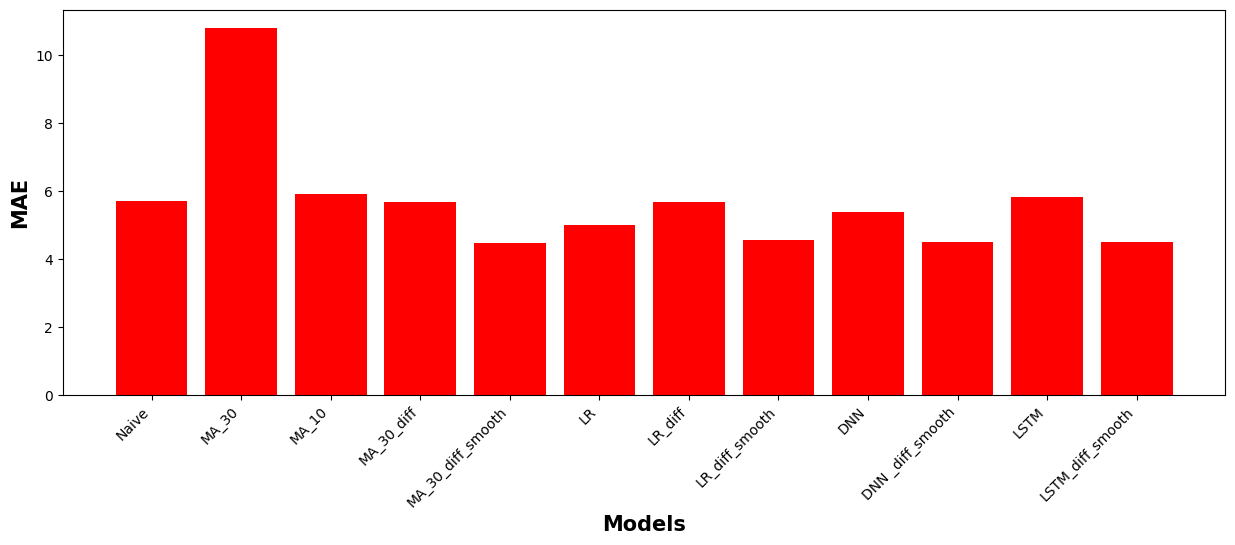

In [126]:
fig = plt.figure(figsize = (15, 5))
plt.bar(x, y_mae, color ='red')
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MAE', fontweight ='bold', fontsize = 15)
plt.xticks(rotation=45, ha='right')

The best solutions are those using differenced data and smoothing method, which will be plotted alone below.

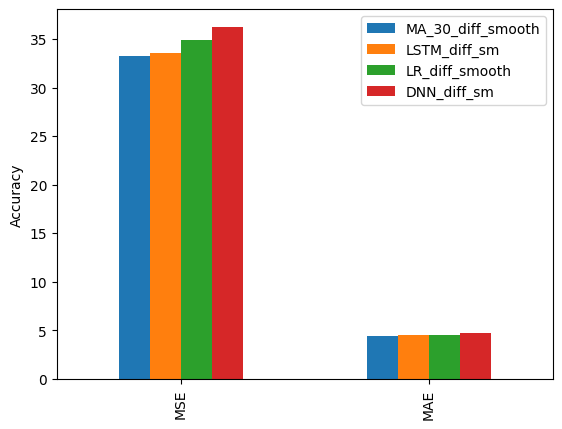

In [128]:
import pandas as pd
x_2 = ['MSE', 'MAE']
y_ma = [MA_30_diff_smooth[0], MA_30_diff_smooth[1]]
y_lr = [LR_diff_smooth[0], LR_diff_smooth[1]]
y_dnn = [DNN_diff_smooth[0], DNN_diff_smooth[1]]
y_lstm = [LSTM_diff_smooth[0], LSTM_diff_smooth[1]]

df = pd.DataFrame({'MA_30_diff_smooth': y_ma,
                   'LSTM_diff_sm': y_lstm,
                   'LR_diff_smooth': y_lr,
                   'DNN_diff_sm': y_dnn,}, index=x_2)

ax = df.plot.bar(ylabel='Accuracy')

The best solution is the Moving average over 30 days with differenced data and smoothing method, followed by the LSTM solution with differenced data and smoothing.